In [25]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import f1_score

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle
import joblib

In [2]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_pitcher_data.dat'

# 교차검증 횟수
cv_count = 10

# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)

# 평가 결과를 담을 리스트
# 필요하다면 다른 것도 만들어주세요
f1_score_list = []
f1_macro_list = []
f1_micro_list = []

# 학습 모델 이름
model_name_list = []

In [3]:
df_pit = pd.read_csv('merged_pitchers_fixed.csv')
df_sal = pd.read_csv('선수 연봉 데이터(등급).csv')

In [4]:
# 1. 칼럼명 변경
df_pit = df_pit.rename(columns={'Name_x': '선수'})

# 2. 칼럼 맞추기
df_pit['pid'] = df_pit['pid'].astype(int)

display(df_pit.head(5))
display(df_sal.head(5))

,pid,선수,포지션,팀,ERA,FIP,WHIP,SO_x,BB_x,HR_x,...,L,S,HD,pit_G,CG,SHO,GR,GF,연봉(만원),WAR
0,10058,양현종,투수,KIA 타이거즈,3.840,4.165,1.295,131.0,44.5,17.0,...,16.0,0.0,0.0,58.0,3.0,0.0,0.0,3.0,100000.0,4.265
1,10075,진해수,투수,LG 트윈스,4.930,5.680,1.785,17.0,10.0,3.5,...,1.0,0.0,7.0,73.0,0.0,0.0,73.0,6.0,40000.0,0.005
2,10124,고효준,투수,SSG 랜더스,6.340,5.140,1.760,46.5,31.0,3.5,...,2.0,0.0,18.0,99.0,0.0,0.0,99.0,9.0,23800.0,0.365
3,10126,김광현,투수,SSG 랜더스,4.230,4.645,1.415,136.5,71.5,17.5,...,18.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,200000.0,4.195
4,10131,박종훈,투수,SSG 랜더스,6.565,6.535,1.685,45.0,40.5,7.5,...,10.0,0.0,0.0,28.0,0.0,0.0,3.0,1.0,160000.0,0.340


,팀,선수,WAR,연봉등급,pid,연도
0,한화 이글스,채은성,2.36,A,11215,2023
1,한화 이글스,최재훈,3.90,B,10170,2023
2,한화 이글스,스미스,0.09,A,15540,2023
3,한화 이글스,오그레디,-0.87,B,15541,2023
4,한화 이글스,이태양,1.44,B,10609,2023


In [5]:
# 병합: pid 기준
df_merged = pd.merge(df_pit, df_sal[['pid', '연봉등급']], on='pid', how='inner')
df_merged

,pid,선수,포지션,팀,ERA,FIP,WHIP,SO_x,BB_x,HR_x,...,S,HD,pit_G,CG,SHO,GR,GF,연봉(만원),WAR,연봉등급
0,10058,양현종,투수,KIA 타이거즈,3.84,4.165,1.295,131.0,44.5,17.0,...,0.0,0.0,58.0,3.0,0.0,0.0,3.0,100000.0,4.265,B
1,10058,양현종,투수,KIA 타이거즈,3.84,4.165,1.295,131.0,44.5,17.0,...,0.0,0.0,58.0,3.0,0.0,0.0,3.0,100000.0,4.265,B
2,10058,양현종,투수,KIA 타이거즈,3.84,4.165,1.295,131.0,44.5,17.0,...,0.0,0.0,58.0,3.0,0.0,0.0,3.0,100000.0,4.265,B
3,10075,진해수,투수,LG 트윈스,4.93,5.680,1.785,17.0,10.0,3.5,...,0.0,7.0,73.0,0.0,0.0,73.0,6.0,40000.0,0.005,C
4,10075,진해수,투수,LG 트윈스,4.93,5.680,1.785,17.0,10.0,3.5,...,0.0,7.0,73.0,0.0,0.0,73.0,6.0,40000.0,0.005,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,16155,발라조빅,투수,두산 베어스,4.26,3.220,1.440,69.0,28.0,3.0,...,0.0,1.0,12.0,0.0,0.0,1.0,0.0,25000.0,1.350,C
880,16160,에르난데스,투수,LG 트윈스,4.02,3.730,1.210,55.0,16.0,5.0,...,1.0,1.0,11.0,0.0,0.0,2.0,1.0,44000.0,1.330,B
881,16160,에르난데스,투수,LG 트윈스,4.02,3.730,1.210,55.0,16.0,5.0,...,1.0,1.0,11.0,0.0,0.0,2.0,1.0,44000.0,1.330,A
882,16161,라우어,투수,KIA 타이거즈,4.93,3.900,1.360,37.0,12.0,3.0,...,0.0,0.0,7.0,0.0,0.0,0.0,0.0,30000.0,0.880,B


In [6]:
# 표준화를 위해 결과데이터를 제외한다.
X = df_merged.drop(['pid', '선수', '포지션', '팀', '연봉(만원)', 'WAR', '연봉등급'], axis=1)

# 표준화
scaler1 = StandardScaler()
scaler1.fit(X)

StandardScaler()

In [7]:
# Segment 인코딩
encoder13 = LabelEncoder()
encoder13.fit(df_merged['연봉등급'])
df_merged['연봉등급'] = encoder13.transform(df_merged['연봉등급'])

In [8]:
# 입력과 결과로 나눈다.
X = df_merged.drop(['pid', '선수', '포지션', '팀', '연봉(만원)', 'WAR', '연봉등급'], axis=1)
y = df_merged['연봉등급']

In [9]:
# 표준화
X = scaler1.transform(X)
X

array([[-0.38153111, -0.03686994, -0.19907055, ..., -0.08266627,
        -0.86120428, -0.41202922],
       [-0.38153111, -0.03686994, -0.19907055, ..., -0.08266627,
        -0.86120428, -0.41202922],
       [-0.38153111, -0.03686994, -0.19907055, ..., -0.08266627,
        -0.86120428, -0.41202922],
       ...,
       [-0.3610383 , -0.03773275, -0.219269  , ..., -0.08266627,
        -0.8113872 , -0.55152897],
       [-0.25743576, -0.03739556, -0.18362468, ..., -0.08266627,
        -0.86120428, -0.62127884],
       [-0.2426354 , -0.03697903, -0.17887211, ..., -0.08266627,
        -0.86120428, -0.62127884]])

In [10]:
train_X = X
train_y = y

### 기본 모델 사용하기

In [13]:
# GradientBoost
gb_basic_model = GradientBoostingClassifier()

# 교차 검증을 수행한다
f1_macro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()


# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoost Basic")

In [14]:
# LGBM
lgbm_basic_model = LGBMClassifier(verbose=-1)

# 교차 검증을 수행한다
f1_macro = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Basic")

In [15]:
# XGBoost
xgboost_basic_model = XGBClassifier(verbose=-1, silent=True)

# 교차 검증을 수행한다
f1_macro = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Basic")

In [16]:
# HardVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

hard_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_basic_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 교차 검증을 수행한다
f1_macro = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Basic")

In [17]:
# SoftVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

soft_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_basic_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Basic")

In [19]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

# 출력
display(result_df)

,Model,F1 Macro,F1 Micro
4,SoftVoting Basic,0.600889,0.683210
0,GradientBoost Basic,0.599555,0.676379
1,LGBM Basic,0.592969,0.678639
3,HardVoting Basic,0.591916,0.678690
2,XGBoost Basic,0.590263,0.679839


### 하이퍼 파라미터 튜닝

In [20]:
# GradientBoosting
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# 기본 모델 정의
temp_model = GradientBoostingClassifier()

# GridSearchCV: f1_macro 기준으로 튜닝
gb_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
gb_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_gb_model = gb_grid_clf.best_estimator_

# f1_macro, f1_micro 각각 평가
f1_macro = cross_val_score(best_gb_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_gb_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoosting Tuning")

In [21]:
# LGBM
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# LGBM 모델 정의
temp_model = LGBMClassifier(
    device='gpu',        # ✅ GPU 사용 설정
    verbose=-1,
    random_state=42
)

# f1_macro 기준으로 하이퍼파라미터 튜닝
lgbm_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
lgbm_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_lgbm_model = lgbm_grid_clf.best_estimator_

# f1_macro, f1_micro 평가
f1_macro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Tuning")

In [22]:
# XGBoost
params = {
    'booster': ['gbtree'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# 모델 정의
temp_model = XGBClassifier(
    tree_method='gpu_hist',       # GPU용 학습 알고리즘
    predictor='gpu_predictor',    # GPU로 예측도 수행
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# f1_macro 기준으로 튜닝
xgboost_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
xgboost_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_xgb_model = xgboost_grid_clf.best_estimator_

# 성능 평가
f1_macro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Tuning")

In [29]:
# HardVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

# 하이퍼 파라미터 셋팅
temp_model7.set_params(**gb_grid_clf.best_params_)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

hard_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_tuning_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 성능 평가 (교차검증)
f1_macro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Tuning")

In [30]:
# SoftVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

# 하이퍼 파라미터 셋팅
temp_model7.set_params(**gb_grid_clf.best_params_)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

soft_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_tuning_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Tuning")

In [31]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

# 출력
display(result_df)

,Model,F1 Macro,F1 Micro
7,XGBoost Tuning,0.631708,0.693309
5,GradientBoosting Tuning,0.614869,0.685393
6,LGBM Tuning,0.605848,0.689913
4,SoftVoting Basic,0.600889,0.683210
9,SoftVoting Tuning,0.600071,0.695595
0,GradientBoost Basic,0.599555,0.676379
1,LGBM Basic,0.592969,0.678639
3,HardVoting Basic,0.591916,0.678690
8,HardVoting Tuning,0.590484,0.688790
2,XGBoost Basic,0.590263,0.679839


### 혼동 행렬 그리기

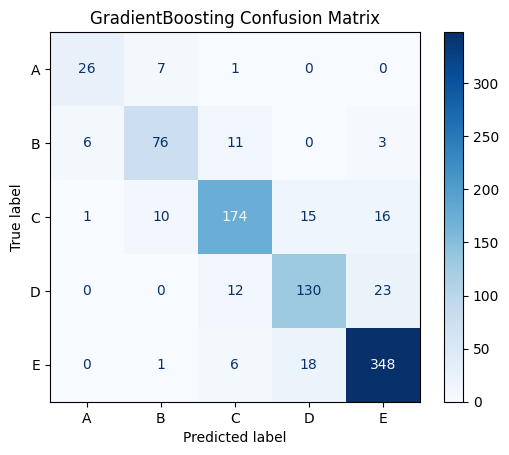

In [26]:
# GradientBoosting
best_gb_model.fit(train_X, train_y)
y_pred = best_gb_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("GradientBoosting Confusion Matrix")
plt.show()

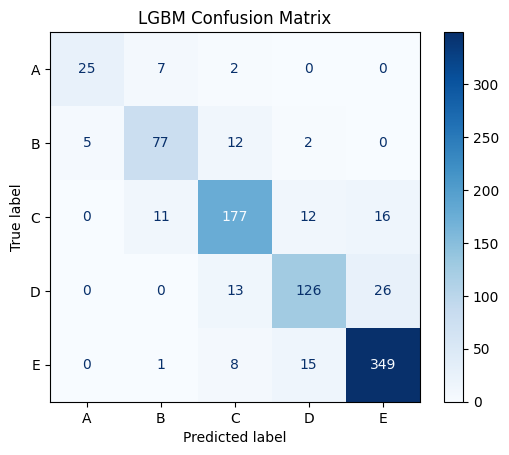

In [27]:
# LGBM
best_lgbm_model.fit(train_X, train_y)
y_pred = best_lgbm_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("LGBM Confusion Matrix")
plt.show()

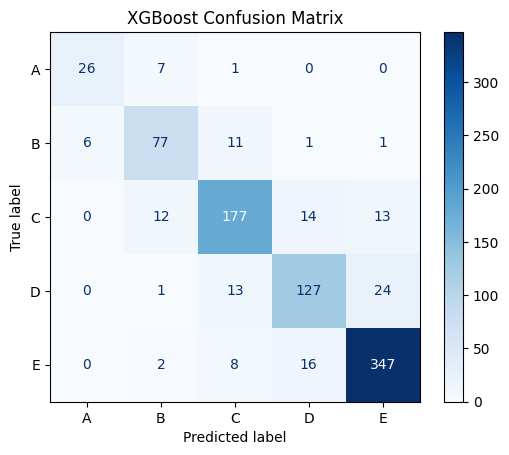

In [28]:
# XGBoost
best_xgb_model.fit(train_X, train_y)
y_pred = best_xgb_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

In [32]:
# 최종 모델을 생성하고 전체 데이터를 학습 시킨다.
best_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
best_model.set_params(**xgboost_grid_clf.best_params_)
best_model.fit(train_X, train_y)
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# 학습 모델 등을 저장한다.
save_objects = {
    'model': best_model,
    #'encoder': encoder1,   # ← 존재할 경우만
    'scaler': scaler1      # ← 존재할 경우만
}

with open(best_model_path, 'wb') as fp:
    pickle.dump(save_objects, fp)

In [36]:
# 저장 확인
# 불러오기
with open(best_model_path, 'rb') as fp:
    loaded = pickle.load(fp)

# 추출
test_model = loaded['model']
test_encoder = loaded.get('encoder')  # 없는 경우 None
test_scaler = loaded.get('scaler')

In [37]:
r1 = test_model.predict(train_X)
r2 = f1_score(train_y, r1, average='macro')  # 또는 'micro'
print("F1 Macro:", r2)

F1 Macro: 0.8248375241651145
